# Arabic Learner Corpus Considerations: Classifier Training and Data Analysis
Anthony Verardi | a.verardi@pitt.edu | 3/17/2020 | University of Pittsburgh

In this Notebook (which is a continuation of [ALC Data Organization](https://github.com/Data-Science-for-Linguists-2020/Arabic-Learner-Corpus-Considerations/blob/master/Notebooks/ALC_Data_Organization.ipynb)), I'll begin the process of analyzing the data obtained from the [Arabic Learner Corpus](https://www.arabiclearnercorpus.com/).

Corpus credit to: Alfaifi, A., Atwell, E. and Hedaya, I. (2014). Arabic Learner Corpus (ALC) v2: A New Written and Spoken Corpus of Arabic Learners. In the proceedings of the Learner Corpus Studies in Asia and the World (LCSAW) 2014, 31 May - 01 Jun 2014. Kobe, Japan. http://www.arabiclearnercorpus.com.

In [19]:
# Importing necessary packages to begin reading in our data. The files come in XML format,
# so we'll need to import a library, BeautifulSoup, that can read them in and get the data
# ready for input into a DataFrame. Glob is for easily working with batches of files at once.

import nltk, glob, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# Allowing for multiple lines of output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_pickle("ALC_df.pkl")

In [3]:
df.head()

,L1,NumLangs,Nationality,Age,Gender,YearsStudy,GenLvl,LvlStdy,Title,Text,Genre,Mode,TextToks,TitleToks,TextLen,TitleLen,TTR,L1family
DocID,,,,,,,,,,,,,,,,,,
S001_T1_M_Pre_NNAS_W_C,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الرحلة إلى القرية لزيارة ذوي القربى,اعتدت الذهاب إلى قريتي في الإجازات الصيفيّة ال...,Narrative,Written,"[اعتدت, الذهاب, إلى, قريتي, في, الإجازات, الصي...","[الرحلة, إلى, القرية, لزيارة, ذوي, القربى]",169,6,0.798817,X
S001_T2_M_Pre_NNAS_W_C,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الجمع بين العلم الشرعي والعلوم الدنيوية لحمزة ...,أحبّ أن ألتحق بكلِّية الشريعة بعد الانتها من ا...,Discussion,Written,"[أحبّ, أن, ألتحق, بكلِّية, الشريعة, بعد, الانت...","[الجمع, بين, العلم, الشرعي, والعلوم, الدنيوية,...",161,9,0.844720,X
S002_T1_M_Pre_NNAS_W_C,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,رحلة الحج المباركة,كتب الله لي أن أحج إلى بيته الحرام السنة الماض...,Narrative,Written,"[كتب, الله, لي, أن, أحج, إلى, بيته, الحرام, ال...","[رحلة, الحج, المباركة]",317,3,0.637224,X
S002_T2_M_Pre_NNAS_W_C,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,أكثر من التخصص,الحمد لله الذي وفقني لدراسة شرعية في جامعة الإ...,Discussion,Written,"[الحمد, لله, الذي, وفقني, لدراسة, شرعية, في, ج...","[أكثر, من, التخصص]",173,3,0.757225,X
S003_T1_M_Pre_NNAS_W_C,Tatar,4,Russian,24,Male,6,Pre-university,Diploma course,رحلتي إلى الجبال,في أحد الأيام الصيف أخبرنا أبي بسفرٍ إلى الغاب...,Narrative,Written,"[في, أحد, الأيام, الصيف, أخبرنا, أبي, بسفرٍ, إ...","[رحلتي, إلى, الجبال]",133,3,0.766917,X


Original language names are not necessarily careful: "Moore", "Ugandan"; classification into families difficult: what level to use, how to preserve unique features? I.e. Russian still Indo-Euro but Slavic feels more appropriate. Might be more of an issue with families themselves than anything else? Want to keep Arabic separate from other Semitic langs

Modnaka?

In [5]:
Austronesian = {"Malay","Maguindanao",'Kalibugan',"Yakan","Maranao",
               "Tagalog","Filipino","Madurese","Indonesian"}
Chadic = {"Anko","Hausa"}
Cushitic = {"Somali","Afar"}
Dravidian = {"Tamil","Malayalam"}
Germanic = {"English", "Dutch", "German"}
IndoIran = {"Persian", 'Bengali', 'Pashto','Tajik', 'Urdu',"Kurdish",
           "Nepali", "Hindi"}
Italic = {"French", "Italian", 'Portuguese'}
NigerCongo = {"Moore","Ugandan","Dagomba","Swahili","Yoruba", "Wolof",
             "Kotokoli", "Fulani", "Beninese", "Bambara", "Soninke",
             "Mandinka","Susu","Jola","Comorian"}
NiloSahar = {"Zarma", "Manga"}
Slavic = {"Russian", "Bosnian", "Serbian","Polish"}
Turkic = {"Tatar","Azerbaijani", "Turkish","Uzbek", "Kyrgyz","Kazakh"}

In [6]:
def l1_fam(x):
    if x['L1'] == "Arabic":
        return "Arabic"
    elif x['L1'] == "Albanian":
        return "Albanian"
    elif x['L1'] == "Amharic":
        return "SemiticNA"
    elif x['L1'] == "Cambodian":
        return "AustroAsiatic"
    elif x['L1'] == 'Korean':
        return "Koreanic"
    elif x['L1'] == "Thai":
        return "KraDai"
    elif x['L1'] == "Mongolian":
        return "Mongolic"
    elif x['L1'] == "Ingush":
        return "NakhDagh"
    elif x['L1'] == "Chinese":
        return "SinoTib"
    elif x['L1'] in Austronesian:
        return "Austronesian"
    elif x['L1'] in Chadic:
        return "Chadic"
    elif x['L1'] in Cushitic:
        return "Cushitic"
    elif x['L1'] in Dravidian:
        return "Dravidian"
    elif x['L1'] in Germanic:
        return "Germanic"
    elif x['L1'] in IndoIran:
        return "IndoIran"
    elif x['L1'] in Italic:
        return "Italic"
    elif x['L1'] in NigerCongo:
        return "NigerCongo"
    elif x['L1'] in NiloSahar:
        return "NiloSahar"
    elif x['L1'] in Slavic:
        return "Slavic"
    elif x['L1'] in Turkic:
        return "Turkic"
    else:
        return "Unclassified"
    
df['L1family'] = df.apply(lambda x: l1_fam(x), axis=1)

In [7]:
df['L1family'].value_counts()

Arabic           790
NigerCongo       176
Austronesian     128
IndoIran         127
SinoTib           76
Italic            48
Turkic            36
Germanic          36
Slavic            35
Chadic            27
Cushitic          27
Dravidian         20
KraDai            19
Albanian           9
AustroAsiatic      9
NiloSahar          7
Unclassified       6
Koreanic           5
SemiticNA          2
NakhDagh           1
Mongolic           1
Name: L1family, dtype: int64

This is as far as I think I'm going to get with everything going on right now. The plan is as follows:

* Add a column for language family (I might go back and do this in the Organization notebook instead)
* Run some tests to see how the data are distributed within learner groups (a Shapiro test might not be needed/useful since there are over 30 observations, but it might still be good to go through)
* Partition data into training, testing, and development sets
* Train a classifier and see if it can reliably tell apart the differences in writing between L1-Arabic learners of Modern Standard Arabic (MSA) and non-L1-Arabic learners of MSA
* Try to eek out what the differences ARE between L1-Arabic learners and non-L1-Arabic learners, and what features are useful indicators of these differences
* I'd like to try another tokenizer that handles Arabic morphosyntax more elegantly (the NLTK version doesn't split words into morphemes, so for+her is rendered as one token instead of "for" and "her" for example), but I could use a hand finding/implementing one

We already know from our organization notebook that the L1 data are not normally distributed, but what about the lengths of the texts themselves? We'll visualize both the raw counts and the TTR values for each. First we'll just look at the raw values, then we'll break them out across L1 partitions.

(0, 1000)

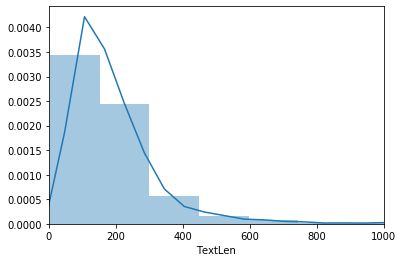

In [8]:
fig, ax = plt.subplots()
sns.distplot(df['TextLen'], ax=ax)
ax.set_xlim(0,1000)
plt.show()

Not the prettiest plot in the world, but it gets the job done. Text length itself is most certainly skewed to the right, with a majority of values clustered in the 0-200 range. The density plot 

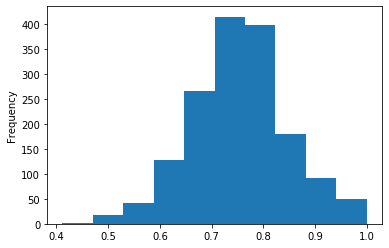

In [9]:
df['TTR'].plot.hist()

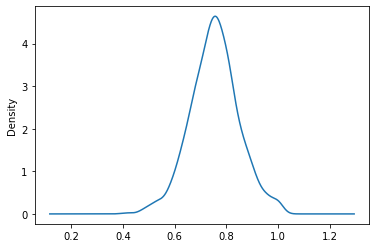

In [10]:
df['TTR'].plot(kind="density")

In [11]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [ ]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
tfIdf = TfidfVectorizer(min_df=2, max_df=.5)

pipe = Pipeline(steps=[('tfIdf', tfIdf),('mlp',mlp)])

# Trying two different solvers, one of which (lbfgs) is supposed to be quicker and better for smaller
# data sets
clf = GridSearchCV(pipe, param_grid = {"tfIdf__max_features":[2000, 5000],
                                      "mlp__solver":('adam','lbfgs')}, cv=5, return_train_score=True)

clf.fit(df.Text, df.L1family)

In [14]:
SVC_model = make_pipeline(TfidfVectorizer(max_features = 5000, min_df=2, max_df=.5), SVC(kernel='rbf', C=1E5))
SVC_model.fit(df.Text, df.L1family)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=5000,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc',
                 SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree

In [21]:
# Labels
labels = SVC_model.predict(df.Text)

# Matrix
matrix = confusion_matrix(df.L1family, labels)

# Accuracy assessment
accuracy = accuracy_score(df.L1family, labels)
accuracy

1.0

In [12]:
svc = sklearn.svm.SVC(kernel='rbf', C=1E5)
tfIdf = TfidfVectorizer()

pipe = Pipeline(steps=[('tfIdf', tfIdf),('svc',svc)])

clf = GridSearchCV(pipe, param_grid = {"tfIdf__max_features":[2000, 5000], 
                                      "tfIdf__min_df":[1,2,3],
                                       "tfIdf__max_df":[.5,.75]}, cv=3, return_train_score=True)

clf.fit(df.Text, df.L1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamm

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfIdf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [13]:
clf.best_params_

{'tfIdf__max_df': 0.5, 'tfIdf__max_features': 5000, 'tfIdf__min_df': 2}

In [22]:
df2 = pd.DataFrame.from_dict(clf.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfIdf__max_df,param_tfIdf__max_features,param_tfIdf__min_df,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.108471,0.330351,0.688157,0.014955,0.5,2000,1,"{'tfIdf__max_df': 0.5, 'tfIdf__max_features': ...",0.530576,0.573055,0.581673,0.560883,0.022547,10,1.0,1.0,1.0,1.0,0.0
1,4.058420,0.277475,0.713581,0.035216,0.5,2000,2,"{'tfIdf__max_df': 0.5, 'tfIdf__max_features': ...",0.528777,0.569260,0.579681,0.558360,0.022147,12,1.0,1.0,1.0,1.0,0.0
2,4.108697,0.290091,0.672570,0.068290,0.5,2000,3,"{'tfIdf__max_df': 0.5, 'tfIdf__max_features': ...",0.530576,0.576850,0.579681,0.561514,0.022771,7,1.0,1.0,1.0,1.0,0.0
3,6.015101,0.619059,0.795745,0.054626,0.5,5000,1,"{'tfIdf__max_df': 0.5, 'tfIdf__max_features': ...",0.530576,0.578748,0.583665,0.563407,0.024215,2,1.0,1.0,1.0,1.0,0.0
4,6.163644,0.497881,0.781046,0.056287,0.5,5000,2,"{'tfIdf__max_df': 0.5, 'tfIdf__max_features': ...",0.534173,0.578748,0.585657,0.565300,0.023049,1,1.0,1.0,1.0,1.0,0.0
5,6.036714,0.568022,0.771125,0.023329,0.5,5000,3,"{'tfIdf__max_df': 0.5, 'tfIdf__max_features': ...",0.530576,0.576850,0.583665,0.562776,0.023828,4,1.0,1.0,1.0,1.0,0.0
6,4.776323,0.762338,0.764576,0.057687,0.75,2000,1,"{'tfIdf__max_df': 0.75, 'tfIdf__max_features':...",0.532374,0.574953,0.581673,0.562145,0.022051,5,1.0,1.0,1.0,1.0,0.0
7,4.919057,0.778456,0.899495,0.180808,0.75,2000,2,"{'tfIdf__max_df': 0.75, 'tfIdf__max_features':...",0.532374,0.574953,0.579681,0.561514,0.021505,7,1.0,1.0,1.0,1.0,0.0
8,5.731319,1.367252,0.760818,0.017181,0.75,2000,3,"{'tfIdf__max_df': 0.75, 'tfIdf__max_features':...",0.532374,0.576850,0.579681,0.562145,0.021914,5,1.0,1.0,1.0,1.0,0.0
9,6.692161,0.747795,0.975996,0.021249,0.75,5000,1,"{'tfIdf__max_df': 0.75, 'tfIdf__max_features':...",0.528777,0.574953,0.589641,0.563407,0.026134,2,1.0,1.0,1.0,1.0,0.0
